In [4]:
from pathlib import Path

# 1. Trouve dynamiquement la racine du projet (contenant .gitignore)
cwd = Path.cwd()
PROJECT_ROOT = next(p for p in (cwd, *cwd.parents) if (p / ".gitignore").exists())

print("PROJECT_ROOT =", PROJECT_ROOT)

PROJECT_ROOT = /home/ubuntu/repository/datasciencetest_reco_plante


In [9]:

!sudo apt-get update
!sudo apt-get install -y libgl1-mesa-glx
!sudo apt-get install -y libgl1-mesa-gl
!pip install opencv-python

Hit:1 http://eu-west-1.ec2.archive.ubuntu.com/ubuntu focal InRelease
Hit:2 http://eu-west-1.ec2.archive.ubuntu.com/ubuntu focal-updates InRelease
Hit:3 http://eu-west-1.ec2.archive.ubuntu.com/ubuntu focal-backports InRelease
Hit:4 http://security.ubuntu.com/ubuntu focal-security InRelease
Reading package lists... Done
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgl1-mesa-glx is already the newest version (21.2.6-0ubuntu0.1~20.04.2).
0 upgraded, 0 newly installed, 0 to remove and 122 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
E: Unable to locate package libgl1-mesa-gl


In [5]:
from pathlib import Path
import pandas as pd
import plotly.express as px
import os
from PIL import Image
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.cluster import DBSCAN
from skimage.feature.texture import graycomatrix as greycomatrix, graycoprops as greycoprops


In [6]:
def black_components_above_size(img_path, threshold=10, min_component_size=200):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    _, mask_black = cv2.threshold(img, threshold, 255, cv2.THRESH_BINARY_INV)
    nb_components, labels, stats, _ = cv2.connectedComponentsWithStats(mask_black)
    sizes = stats[1:, cv2.CC_STAT_AREA]  # ignorer le fond (composant 0)
    large_components = [s for s in sizes if s >= min_component_size]
    nb_large_components = len(large_components)
    
    # Filtrer le masque pour ne garder que les composants > taille seuil
    filtered_mask = np.zeros_like(mask_black)
    for i, size in enumerate(sizes, start=1):
        if size >= min_component_size:
            filtered_mask[labels == i] = 255
    return nb_large_components

# Pourquoi en niveaux de gris ?
# Réduit la complexité (1 canal) tout en conservant l’information d’intensité noire/blanche.
# Seuillage inversé
# Isole précisément les zones sombres (pixel intensité ≤ threshold) en blanc pour le traitement de composantes.
# Connected Components
# Permet de regrouper les pixels contigus en « régions » identifiées, et d’obtenir leurs statistiques (aire, bounding box…).
# Filtrage par aire
# Élimine le bruit (petites taches), ne gardant que les régions significatives (> min_component_size).
# Masque final
# Utile pour visualiser ou quantifier précisément ces régions (analyse de taille, forme ou position).

In [ ]:
# import os
# print("Répertoire de travail :", os.getcwd())

Répertoire de travail : /home/ubuntu/repository/datasciencetest_reco_plante/notebooks


In [ ]:
# from pathlib import Path

# img_path = Path("../dataset/plantvillage/data/plantvillage_5images/segmented/Apple___Apple_scab/01a66316-0e98-4d3b-a56f-d78752cd043f___FREC_Scab 3003_final_masked.jpg")
# print("Existe ?", img_path.exists())
# print("Liste du dossier parent :", list(img_path.parent.iterdir()))

Existe ? True
Liste du dossier parent : [PosixPath('../dataset/plantvillage/data/plantvillage_5images/segmented/Apple___Apple_scab/00075aa8-d81a-4184-8541-b692b78d398a___FREC_Scab 3335_final_masked.jpg'), PosixPath('../dataset/plantvillage/data/plantvillage_5images/segmented/Apple___Apple_scab/023123cb-7b69-4c9f-a521-766d7c8543bb___FREC_Scab 3487_final_masked.jpg'), PosixPath('../dataset/plantvillage/data/plantvillage_5images/segmented/Apple___Apple_scab/0208f4eb-45a4-4399-904e-989ac2c6257c___FREC_Scab 3037_final_masked.jpg'), PosixPath('../dataset/plantvillage/data/plantvillage_5images/segmented/Apple___Apple_scab/01a66316-0e98-4d3b-a56f-d78752cd043f___FREC_Scab 3003_final_masked.jpg'), PosixPath('../dataset/plantvillage/data/plantvillage_5images/segmented/Apple___Apple_scab/01f3deaa-6143-4b6c-9c22-620a46d8be04___FREC_Scab 3112_final_masked.jpg')]


In [7]:
import cv2

img_path = "../dataset/plantvillage/data/plantvillage_5images/segmented/Apple___Apple_scab/01a66316-0e98-4d3b-a56f-d78752cd043f___FREC_Scab 3003_final_masked.jpg"
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
if img is None:
    raise FileNotFoundError(f"Impossible de charger l’image : {img_path}")
print("Shape:", img.shape, "dtype:", img.dtype)

Shape: (256, 256) dtype: uint8


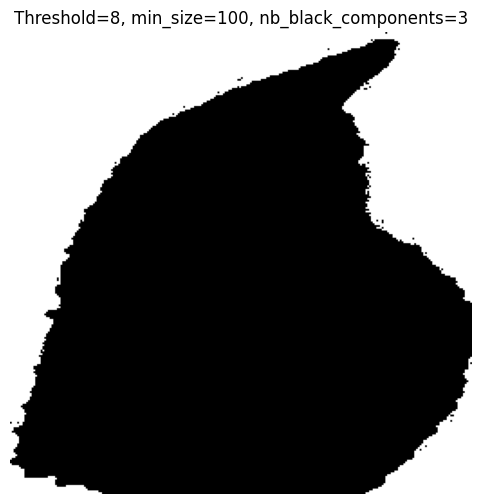

In [ ]:

# def black_components_above_size(img_path, threshold, min_component_size):
#     """
#     Détecte et compte les zones noires (composants connexes) dans une image 
#     qui dépassent une certaine taille, et renvoie un masque ne conservant 
#     que ces gros composants.

#     — Utilité globale : 
#       • Identifier des artefacts ou zones d’intérêt (par ex. lésions sombres, 
#         taches noires) sur l’image.  
#       • Filtrer les petites imperfections (bruit) en ne gardant que les régions 
#         assez grandes pour être pertinentes.
#     """
#     # 1) Chargement en niveaux de gris pour simplifier le traitement
#     img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

#     # 2) Seuillage inverse : tout pixel > threshold devient 0, ≤ threshold devient 255
#     #    → on obtient un masque où les zones sombres (noires) d’origine passent à blanc.
#     _, mask_black = cv2.threshold(
#         img, threshold, 255, cv2.THRESH_BINARY_INV
#     )

#     # 3) Labelisation des composants connexes
#     #    nb_components : nombre total (inclut le fond)
#     #    labels        : matrice de labels pour chaque pixel
#     #    stats         : stats[composant, propriété] (aire, b-box, etc.)
#     nb_components, labels, stats, _ = cv2.connectedComponentsWithStats(mask_black)

#     # 4) Extraction des aires (en pixels) de chaque composant (on ignore l’index 0 = fond)
#     sizes = stats[1:, cv2.CC_STAT_AREA]

#     # 5) Comptage des composants assez grands
#     large_components = [s for s in sizes if s >= min_component_size]
#     nb_large_components = len(large_components)

#     # 6) Reconstruction d’un masque ne conservant que les composants ≥ taille seuil
#     filtered_mask = np.zeros_like(mask_black)
#     for i, size in enumerate(sizes, start=1):
#         if size >= min_component_size:
#             filtered_mask[labels == i] = 255

#     # 7) On renvoie le nombre de gros composants et le masque filtré
#     return nb_large_components, filtered_mask


# # img_path = "/Users/mackjb/repository/datasciencetest_reco_plante/dataset/plantvillage/data/plantvillage_5images/segmented/Apple___Apple_scab/01f3deaa-6143-4b6c-9c22-620a46d8be04___FREC_Scab 3112_final_masked.jpg"
# img_path = "../dataset/plantvillage/data/plantvillage_5images/segmented/Apple___Apple_scab/01a66316-0e98-4d3b-a56f-d78752cd043f___FREC_Scab 3003_final_masked.jpg"


# min_sizes = [100, 2000, 5000, 10000]

# plt.figure(figsize=(10, 6))

# for threshold in range(
#     8, 11):
#     for min_size in min_sizes:
#         nb_components, filtered_mask = black_components_above_size(img_path, threshold, min_size)
#         plt.imshow(filtered_mask, cmap='gray')
#         plt.title(f"Threshold={threshold}, min_size={min_size}, nb_black_components={nb_components}")
#         plt.axis('off')
#         plt.show()
#         input("Appuie sur Enter pour continuer...")
        
        
        

In [8]:
import numpy as np
from PIL import Image

# Après avoir binaire l’image (seuillage) segmented, il suffit de regarder si des pixels “feuille” sont présents sur les bords (haut, bas, gauche, droite).
def touches_border(img_path, threshold=15):
    img = Image.open(img_path).convert('L')
    arr = np.array(img)
    mask = arr > threshold  # Pixels de la feuille (fond noir = 0)
    h, w = mask.shape

    touches = {
        'top': mask[0, :].any(),
        'bottom': mask[-1, :].any(),
        'left': mask[:, 0].any(),
        'right': mask[:, -1].any()
    }
    return any(touches.values()), touches


In [1]:
# Calculs à effectuer sur le dataframe :
# 1 >>> Caractéristiques de couleur:
# 1.1 Moyenne et écart-type par canal (RGB, HSV ou Lab)
# Pourquoi ? Les maladies (taches, jaunissement…) et les espèces ont souvent des signatures couleur distinctes.
# 1.2 Histogrammes de couleur (p. ex. 16 bins par canal)
# Pourquoi ? Capturent la distribution globale des teintes, plus fine que la moyenne.

# 2 >>> Caractéristiques de texture
# 2.1 Local Binary Patterns (LBP)
# Pourquoi ? Très efficace pour discriminer textures rugueuses (maladies, nervures).
# 2.2 Haralick (GLCM) : contraste, homogénéité, énergie, corrélation…
# Pourquoi ? Quantifient la façon dont les pixels de différentes intensités co-apparaissent, sensible aux motifs de la surface de la feuille.

# 3 >>> Caractéristiques de forme et de contour
# (nécessite un pré-traitement de seuillage ou détection de contour)
# 3.1 Rapport d’aspect, aire, périmètre, convexité, « extent » (aire/boîte englobante)
# Pourquoi ? Différencient les espèces par la forme des feuilles.
# 3.2 Histogramme de gradients orientés (HOG)
# Pourquoi ? Modélise la structure globale et les nervures comme un vecteur de gradients normalisés.

# 4 >>> Caractéristiques fréquentielles
# 4.1 Transformée en ondelettes (energies par bande)
# Pourquoi ? Sépare détails fins (taches, bords) et structures grossières.



In [6]:
!conda install -c conda-forge pywavelets scikit-image

Channels:
 - conda-forge
 - defaults
Platform: linux-64
Solving environment: | 

In [9]:
import os
import cv2
import numpy as np
from PIL import Image
import skimage
print("scikit-image version:", skimage.__version__)

# ––– texture & contours –––
from skimage.feature import local_binary_pattern, hog

# GLCM (gestion multi-versions de skimage ≥0.20 ou <0.20)
try:
    from skimage.feature.texture import greycomatrix, greycoprops
except ImportError:
    try:
        from skimage.feature import graycomatrix as greycomatrix, graycoprops as greycoprops
    except ImportError:
        from skimage.feature import greycomatrix, greycoprops

# ondelettes
#import pywt

# data
import pandas as pd

scikit-image version: 0.25.2


In [11]:
# FEATURES LIEES AUX COULEURS
########################################################
###### Histogramme de couleur (16 bins par canal)   ###### 
########################################################

# • Distribution fine des intensités (pics en zones malades)• Séparation de feuilles de même moyenne mais tachetées
# • cv2.calcHist([img],[c],mask,16,[0,256]) + normalisation manuelle
# on fait 16 bins par canal (R/G/B), normalisés pour comparer entre images.
# Principe : Pour chaque canal, on découpe l’intervalle [0–255] en 16 “bacs” et on compte la fréquence de pixels dans chacun, puis on normalise.
# Donne :
#   * La distribution complète des intensités, pas seulement sa moyenne.
#   * Les maladies créent souvent des crêtes secondaires dans l’histogramme (ex. pic autour de 200 pour une zone nécrosée).
# >>> Nous permettra de différencier deux feuilles de même moyenne mais avec des taches localisées (histogrammes multi-pics vs uni-modal).
# Offre un vecteur de taille fixe, robuste aux différences de luminosité.

########################################################
# FEATURES LIEES A LA TEXTURE
########################################################
###### Local Binary Patterns (LBP)   ######
########################################################

# • Micro-textures (nervures fines, ponctuations de maladie)• Robuste aux variations d’éclairage
# • skimage.feature.local_binary_pattern(gray, P=24, R=3, method='uniform')
# on calcule l’histogramme des motifs binaires (uniform patterns) pour résumer la texture locale
# Principe : pour chaque pixel centre, on compare sa valeur à celles de ses P voisins sur un cercle de rayon R.
# On encode en binaire (1 si voisin ≥ centre, 0 sinon) puis on convertit en entier sur P bits.
# On construit l’histogramme de ces codes LBP sur l’image.
# Donne :
#   * Les micro-texturations : nervures fines, relief de la surface, petits points ou taches.
#   * Très sensible aux motifs réguliers vs irréguliers (une feuille saine a un LBP plus homogène qu’une surface piquée).
# >>> Segmentation non supervisée de zones texturées (maladie vs zone saine).
# Robuste aux changements d’éclairage (comparaison locale).


########################################################
# FEATURES LIEES A LA FORME / CONTOUR
# /!\ Pré-traitement : binarisation (par seuillage adaptatif ou Otsu), extraction des contours (Canny, findContours)
########################################################
###### Histogramme de gradients orientés (HOG)   ######
########################################################

# • Structure veineuse / contours primaires• Vecteur robuste aux décalages de position et d’échelle
# • skimage.feature.hog(gray, pixels_per_cell=(8,8), cells_per_block=(2,2))
# la fonction hog de scikit-image renvoie un vecteur de descripteurs de contours et orientations.
# Principe :On calcule les gradients (∂I/∂x, ∂I/∂y) en chaque pixel.
# On divise l’image en cellules (ex. 8×8 px), on calcule l’orientation du gradient et on remplit un histogramme de 9 bins par cellule.
# On normalise par bloc (pour l’éclairage) et on concatène tous les histograms.
# Donne :
#   * La structure veineuse et les gros contours.
#   * Orientations dominantes (nervures primaires vs secondaires).
# >>> Fournit un vecteur robuste aux légers décalages de position/échelle.
# Très utilisé en détection d’objets : ici, pour reconnaître la géométrie interne d’une feuille.
    
########################################################
# FEATURES FREQUENTIELLES
########################################################
###### Énergies de sous-bandes ondelettes (DWT)   ######
########################################################

# • Séparation multi-échelle – basses fréquences : forme – hautes fréquences : détails de taches, bords nets
# • import pywt; coeffs = pywt.dwt2(gray, 'db1') → calcul des énergies
# on prend une ondelette Haar (niveau 1) et on en extrait l’énergie moyenne des coefficients d’approximation (cA) et des détails (cH, cV, cD).
# Principe : On applique une Transformée en Ondelettes Discrète (DWT) : chaque niveau décompose l’image en sous-bandes (LL, LH, HL, HH).
# On calcule l’énergie (somme des carrés) dans chaque sous-bande.
# Donne :
#   * LL (low–low) : structures grossières (forme générale).
#   * LH/HL/HH : détails horizontaux/verticaux/diagonaux (bords nets, bords flous).
# >>> Sépare automatiquement les échelles d’information.
# Les petits défauts (taches, spores) ressortent dans les hautes fréquences, tandis que la forme reste dans les basses fréquences.

# BILAN : Diversité des features (couleur, texture, forme, fréquence) qui donneront au modèle ML une représentation riche et complémentaire.
# Un Random Forest ou un SVM exploitera ces vecteurs hétérogènes pour séparer classes d’espèces et signaux de maladies avant de passer à un CNN plus coûteux.
# En phase d’analyse exploratoire, ces caractéristiques permettent aussi de visualiser les clusters, vérifier la séparation linéaire ou non, et guider la sélection de variables.

# AUTRES FAMILLES DE FEATURES ET DE FEATURES QU'ON AURAIT PU UTILISER
# 1. Descripteurs de couleur avancés

    # Moments de couleur d’ordre supérieur (skewness, kurtosis)

        # Quoi ? Troisième et quatrième moments (asymétrie, aplatissement) de la distribution de chaque canal.

        # Pourquoi utile ? Permettent de détecter des queues ou des pics très localisés (taches nécrotiques intenses).

    # Coefficients de corrélation inter-canaux

        # Quoi ? Corrélation entre, par exemple, R et G sur tous les pixels.

        # Pourquoi utile ? Les nuances de brun/rouge caractéristiques de certaines maladies dépendent du mélange précis de deux canaux.

# 2. Descripteurs de texture multi-échelle

    # Filtres de Gabor

        # Quoi ? Banques de filtres sinusoïdaux modulés par une gaussienne, à différentes fréquences et orientations.

        # Pourquoi utile ? Capturent des motifs texturaux à différentes échelles et directions — par ex. nervures fines vs gros plis.

    # Histogramme d’arêtes (Edge Histogram Descriptor)

        # Quoi ? On découpe l’image en blocs, on détecte les arêtes horizontales, verticales, diagonales… et on construit un histo.

        # Pourquoi utile ? Mesure la densité et la direction dominante des arêtes, sensible à la structure veineuse.

# 3. Descripteurs de forme et géométrie étendue

    # Descripteurs de Fourier des contours

        # Quoi ? On encode le contour comme une courbe complexe et on calcule son spectre de Fourier.

        # Pourquoi utile ? Permet d’obtenir une représentation invariante à la translation, la rotation et l’échelle de la forme de la feuille.

    # Moments invariants de Hu (déjà évoqués) et Zernike

        # Quoi ? Moments calculés sur la forme binaire, Zernike offrant une base orthogonale sur le disque.

        # Pourquoi utile ? Invariants géométriques puissants pour reconnaître des espèces même si la feuille est tournée ou redimensionnée.

    # Longueur totale du squelette et nombre de bifurcations

        # Quoi ? Après squelette morphological, on mesure sa longueur et compte les intersections.

        # Pourquoi utile ? Car les nervures primaires/secundaires forment des graphes dont la topologie varie selon l’espèce.

# 4. Descripteurs basés sur points clés (Keypoints)

    # Bag-of-Visual-Words (SIFT / SURF / ORB)

        # Quoi ? On extrait des points d’intérêt, on quantifie leurs descripteurs locaux et on agrège en histogramme “vocabulaire visuel”.

        # Pourquoi utile ? Capture les motifs locaux caractéristiques (taches, piqûres, nervures) sans a priori sur la forme ou la couleur.

    # Densité de coins (Harris, Shi-Tomasi)

        # Quoi ? Nombre de coins détectés par unité de surface.

        # Pourquoi utile ? Les zones de transition feuille-fond ou feuilles-maladies ont souvent des coins marqués.

# 5. Descripteurs statistiques globaux et topologiques

    # Dimension fractale

        # Quoi ? Exposant qui décrit la complexité du contour ou de la texture (méthode “box-counting”).

        # Pourquoi utile ? Les feuilles très dentelées ou très piquetées ont une dimension fractale plus élevée.

    # Descripteurs de Graphes (centre de gravité, diamètre de graphe)

        # Quoi ? On modélise le réseau de nervures comme un graphe et on mesure son diamètre, sa densité, etc.

        # Pourquoi utile ? Distingue architectures veineuses d’espèces et stades de développement/maladie.

# Pourquoi avoir privilégié les premiers ?

    # Simplicité et rapidité de calcul

        # Moyenne/écart-type, histogrammes, LBP, Haralick et HOG sont directement implémentés dans la plupart des bibliothèques (OpenCV, scikit-image), et peu coûteux.

    # Interpretabilité

        # Ces descripteurs sont faciles à expliquer (« la texture rugueuse d’une feuille malade », « la forme ovale typique de l’espèce X ») — un atout pour un projet scolaire.

    # Couverture complémentaire

        # Ils couvrent quatre axes (couleur, texture, forme, fréquence) qui, ensemble, donnent une représentation riche et discriminante sans se recouvrir.

    # Efficacité prouvée

        # Dans la littérature sur la reconnaissance de feuilles et la détection de maladies, ces descripteurs classiques sont très souvent utilisés comme base avant d’ajouter des méthodes plus sophistiquées ou un réseau de neurones.

# >>> On commence par les features fiables, rapides, faciles à interpréter et démontrées efficaces. Une fois qu’ils sont en place, on enrichira avec les méthodes plus avancées listées ci-dessus si le besoin de performance ou de robustesse supplémentaire se fait sentir.


In [10]:
def plot_color_histogram(img_path: str, bins: int = 16, save_path: str = None):
    """
    Charge une image segmentée, calcule et affiche (ou enregistre) 
    l'histogramme normalisé pour chaque canal R, G, B.
    """
    if not os.path.isfile(img_path):
        raise FileNotFoundError(f"Impossible de charger l'image : {img_path}")

    # Lecture et conversion BGR → RGB
    img_bgr = cv2.imread(img_path, cv2.IMREAD_COLOR)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    # Séparation des canaux
    channels = cv2.split(img_rgb)
    channel_names = ['R', 'G', 'B']
    colors = ['red', 'green', 'blue']

    # Création de la figure
    fig, axes = plt.subplots(1, 3, figsize=(12, 4), tight_layout=True)
    for ax, ch, name, col in zip(axes, channels, channel_names, colors):
        hist = cv2.calcHist([ch], [0], None, [bins], [0, 256]).flatten()
        hist /= (hist.sum() + 1e-6)
        ax.bar(range(bins), hist, color=col, alpha=0.7)
        ax.set_title(f"Canal {name}")
        ax.set_xlabel("Bin")
        ax.set_ylabel("Proportion")
        ax.set_xlim(0, bins - 1)

    if save_path:
        # plt.savefig pour enregistrer chaque histogramme dans le dossier 
        plt.savefig(save_path, dpi=150)
        plt.close(fig)
    else:
        plt.show()

In [11]:
# root_dir déjà défini
root_dir = PROJECT_ROOT/"dataset"/"plantvillage"/"data"/"plantvillage_5images"/"segmented"
# root_dir = PROJECT_ROOT/"dataset"/"plantvillage"/"data"/"plantvillage dataset"/"segmented"



# TODO IL FAUT CALCULER 
########################################################


data = []
for subdir, dirs, files in os.walk(root_dir):
    for file in files:
        if not file.lower().endswith(('.jpg','.jpeg','.png')):
            continue

        filepath = os.path.join(subdir, file)
        rel_path = os.path.relpath(filepath, root_dir)
        parts = rel_path.split(os.sep)
        # extraction class/disease
        if len(parts)>=2 and "___" in parts[0]:
            plant_class, disease = parts[0].split('___',1)
        elif len(parts)>=3:
            plant_class, disease = parts[0], parts[1]
        else:
            plant_class, disease = parts[0], None
        ext = os.path.splitext(file)[1].lower().lstrip('.')

        # init
        width = height = None
        area = peri = asp_ratio = extent = solidity = 0
        mean_col = [None, None, None]
        std_col  = [None, None, None]
        contrast = homogeneity = energy = correlation = None

        try:
            img_pil = Image.open(filepath).convert('RGB')
            width, height = img_pil.size
            arr = np.array(img_pil)
            gray = cv2.cvtColor(arr, cv2.COLOR_RGB2GRAY)

            # -> Forme
            # Binarisation : seuil pour isoler la lésion  
            # → convertit en image binaire où tout pixel >10 devient blanc (255)  
            _, thresh = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)

            # Détection des contours externes  
            # → récupère toutes les formes blanches, on choisit la plus grosse (la lésion)  
            cnts, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            if cnts:
                cnt = max(cnts, key=cv2.contourArea)

                # 1) Forme géométrique
                area = cv2.contourArea(cnt)
                #   • area : surface de la lésion (nombre de pixels) → taille infectée
                peri = cv2.arcLength(cnt, True)
                #   • peri : longueur du contour → complexité/irrégularité du bord

                x, y, w, h = cv2.boundingRect(cnt)
                asp_ratio = w/h if h>0 else 0
                #   • asp_ratio (rapport w/h) : différencie formes allongées vs rondes
                extent = area/(w*h) if w*h>0 else 0
                #   • extent : compacité par rapport au rectangle englobant

                hull = cv2.convexHull(cnt)
                solidity = area/cv2.contourArea(hull) if cv2.contourArea(hull)>0 else 0
                #   • solidity : proportion surface/convex hull → quantifie les indentations
            else:
                # pas de contour détecté → valeurs nulles
                area = peri = asp_ratio = extent = solidity = 0

            # 2) Couleur globale
            # → moyenne et écart-type par canal RGB pour capturer la teinte dominante et le contraste chromatique
            mean_col = arr.mean(axis=(0,1)).tolist()    # [mean_R, mean_G, mean_B]
            std_col  = arr.std(axis=(0,1)).tolist()     # [std_R,  std_G,  std_B]

            # 3) Texture (GLCM : Grey Level Co-occurrence Matrix)
            # → quantifie motifs et rugosité
            glcm = greycomatrix(
                gray,
                distances=[1],       # pixel adjacent
                angles=[0],          # horizontal
                levels=256,
                symmetric=True,
                normed=True
            )
            contrast    = greycoprops(glcm, 'contrast')[0,0]
            #   • contrast : intensité des variations → granulosité
            homogeneity = greycoprops(glcm, 'homogeneity')[0,0]
            #   • homogeneity : uniformité → présence de zones régulières
            energy      = greycoprops(glcm, 'energy')[0,0]
            #   • energy : ordre des motifs → degré de répétitivité
            correlation = greycoprops(glcm, 'correlation')[0,0]
            #   • correlation : similarité spatiale → structure et alignement des textures

            # 4) Histogramme de couleur (normalisé, 16 bins par canal)
            hist_bins = 16
            color_hist = []
            for ch in range(3):
                h = cv2.calcHist([arr], [ch], None, [hist_bins], [0,256]).flatten()
                h = h / (h.sum() + 1e-6)
                color_hist.extend(h.tolist())

            # 5) LBP (uniform patterns, P=8, R=1)
            radius = 1
            n_points = 8 * radius
            lbp = local_binary_pattern(gray, n_points, radius, method='uniform')
            lbp_hist, _ = np.histogram(
                lbp.ravel(),
                bins=np.arange(0, n_points + 3),
                range=(0, n_points + 2)
            )
            lbp_hist = (lbp_hist / (lbp_hist.sum() + 1e-6)).tolist()

            # 6) HOG
            # fd_hog, _ = hog(
            #     gray,
            #     orientations=9,
            #     pixels_per_cell=(8, 8),
            #     cells_per_block=(2, 2),
            #     block_norm='L2-Hys',
            #     visualize=True,
            #     feature_vector=True
            # )
            # hog_feat = fd_hog.tolist()

            # 7) DWT (1 niveau, ondelette Haar)
            # coeffs2 = pywt.dwt2(gray, 'haar')
            # cA, (cH, cV, cD) = coeffs2
            # on stocke l'énergie moyenne de chaque sous-bande
            # dwt_feats = [
            #     np.mean(np.abs(cA)),
            #     np.mean(np.abs(cH)),
            #     np.mean(np.abs(cV)),
            #     np.mean(np.abs(cD))
            # ]

        except Exception as e:
            print(f"Erreur calcul features supplémentaires sur {filepath}:", e)
            color_hist = [0] * (3 * 16)
            lbp_hist   = [0] * (n_points + 2)
            hog_feat   = []
            #dwt_feats  = [0, 0, 0, 0]

        data.append({
            "filepath": filepath,
            "filename": file,
            "class": plant_class,
            "disease": disease,
            "extension": ext,
            "width": width,
            "height": height,
            "touches_border": touches_border(filepath),             # si la lésion touche le bord
            "result": black_components_above_size(filepath, 2000, 10),
            # géométrie
            "area": area,
            "perimeter": peri,
            "aspect_ratio": asp_ratio,
            "extent": extent,
            "solidity": solidity,
            # couleur
            "mean_R": mean_col[0], "mean_G": mean_col[1], "mean_B": mean_col[2],
            "std_R":  std_col[0],  "std_G":  std_col[1],  "std_B":  std_col[2],
            # texture
            "glcm_contrast":    contrast,
            "glcm_homogeneity": homogeneity,
            "glcm_energy":      energy,
            "glcm_correlation": correlation,
            # histogramme couleur
            **{f"col_hist_bin{i}": color_hist[i] for i in range(len(color_hist))},
            # LBP
            **{f"lbp_bin{i}": lbp_hist[i] for i in range(len(lbp_hist))},
            # HOG
            #**{f"hog_feat{i}": hog_feat[i] for i in range(len(hog_feat))},
            # DWT
            #"dwt_cA_mean": dwt_feats[0],
            #"dwt_cH_mean": dwt_feats[1],
            #"dwt_cV_mean": dwt_feats[2],
            #"dwt_cD_mean": dwt_feats[3],
        })

# Construction du DataFrame
df = pd.DataFrame(data)
df_sorted = df.sort_values(by="filepath").reset_index(drop=True)
df_sorted.head()
# tri
df_sorted.head(25)
print(df_sorted.head(25))

# Génération des histogrammes pour chaque image
# Création du dossier results/histograms/ pour y stocker chaque image d’histogramme
out_dir = PROJECT_ROOT / "results" / "histograms"
os.makedirs(out_dir, exist_ok=True)

# fonction plot_color_histogram utilisée à chaque itération
for idx, row in df_sorted.iterrows():
    img_path  = row["filepath"]
    base_name = os.path.splitext(os.path.basename(img_path))[0]
    save_png  = out_dir / f"hist_{idx:04d}_{base_name}.png"
    try:
        # save_path=None pour afficher les histogrammes
        plot_color_histogram(str(img_path), bins=16, save_path=str(save_png))
        print(f"[OK] {save_png.name}")
    except Exception as e:
        print(f"[ERREUR] {img_path}: {e}")
# ----------------------------------------------------------------- #

# Sauvegarde finale du DataFrame dans un .csv
output_csv = PROJECT_ROOT / "results" / "plantvillage_features2.csv"
df_sorted.to_csv(output_csv, index=False, encoding="utf-8")
print(f"CSV généré : {output_csv}")




                                             filepath  \
0   /home/ubuntu/repository/datasciencetest_reco_p...   
1   /home/ubuntu/repository/datasciencetest_reco_p...   
2   /home/ubuntu/repository/datasciencetest_reco_p...   
3   /home/ubuntu/repository/datasciencetest_reco_p...   
4   /home/ubuntu/repository/datasciencetest_reco_p...   
5   /home/ubuntu/repository/datasciencetest_reco_p...   
6   /home/ubuntu/repository/datasciencetest_reco_p...   
7   /home/ubuntu/repository/datasciencetest_reco_p...   
8   /home/ubuntu/repository/datasciencetest_reco_p...   
9   /home/ubuntu/repository/datasciencetest_reco_p...   
10  /home/ubuntu/repository/datasciencetest_reco_p...   
11  /home/ubuntu/repository/datasciencetest_reco_p...   
12  /home/ubuntu/repository/datasciencetest_reco_p...   
13  /home/ubuntu/repository/datasciencetest_reco_p...   
14  /home/ubuntu/repository/datasciencetest_reco_p...   
15  /home/ubuntu/repository/datasciencetest_reco_p...   
16  /home/ubuntu/repository/dat

<Figure size 1000x400 with 0 Axes>

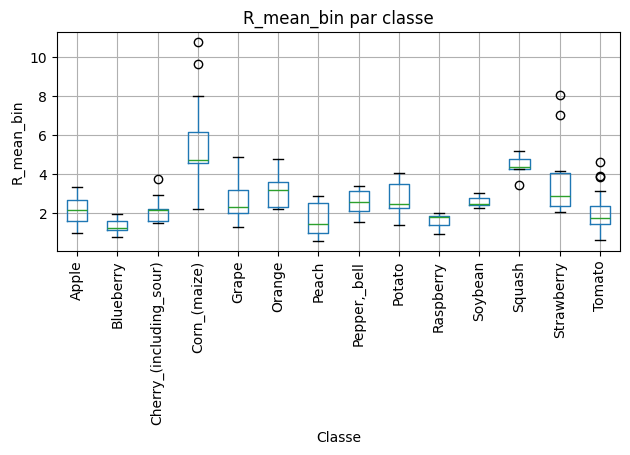

<Figure size 1000x400 with 0 Axes>

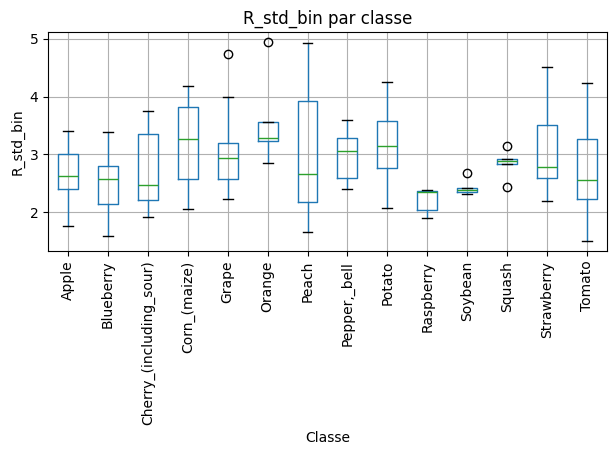

<Figure size 1000x400 with 0 Axes>

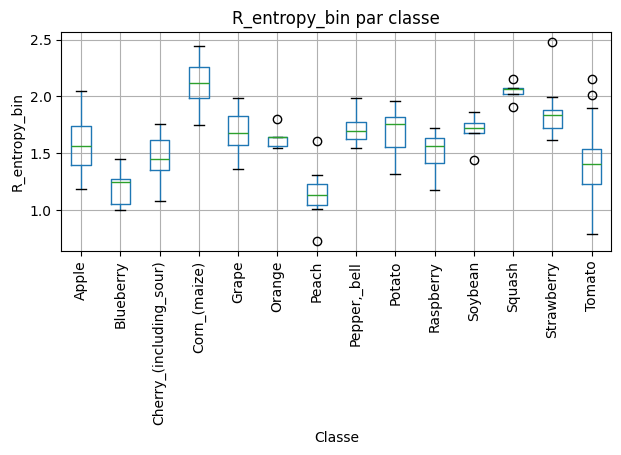

<Figure size 1000x400 with 0 Axes>

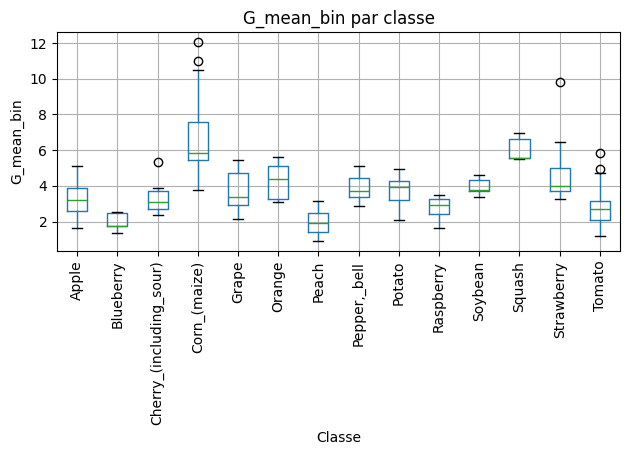

<Figure size 1000x400 with 0 Axes>

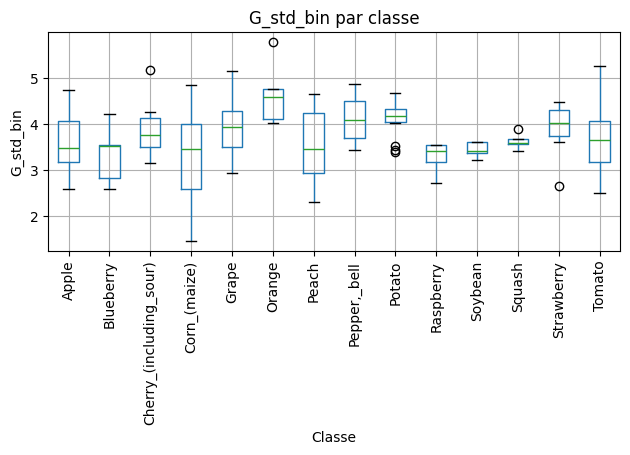

<Figure size 1000x400 with 0 Axes>

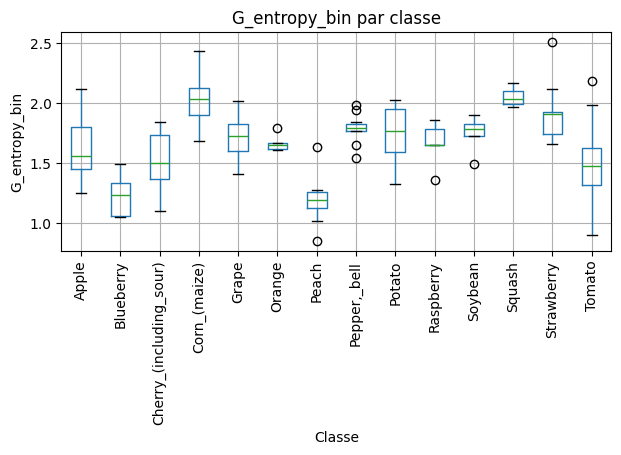

<Figure size 1000x400 with 0 Axes>

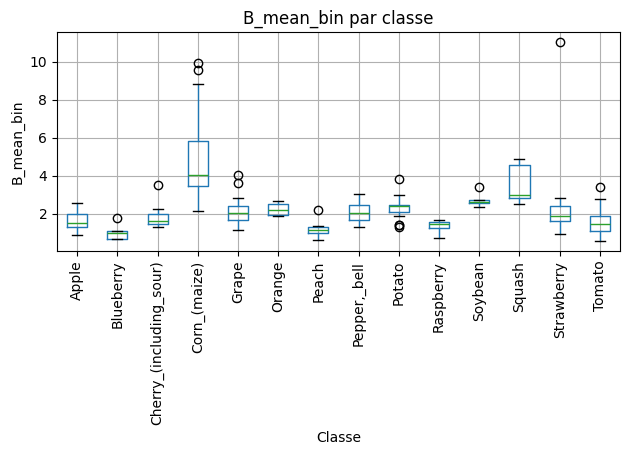

<Figure size 1000x400 with 0 Axes>

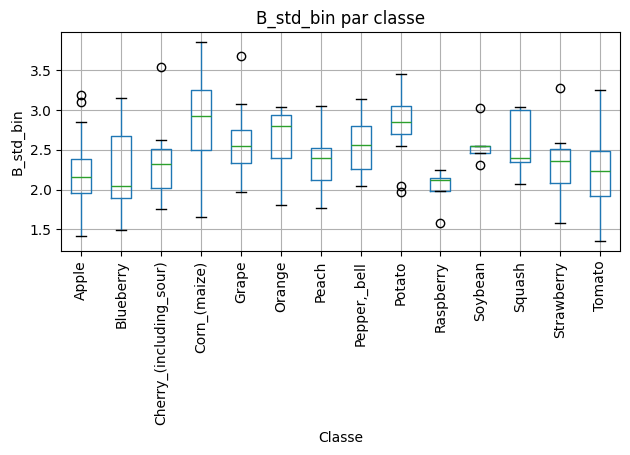

<Figure size 1000x400 with 0 Axes>

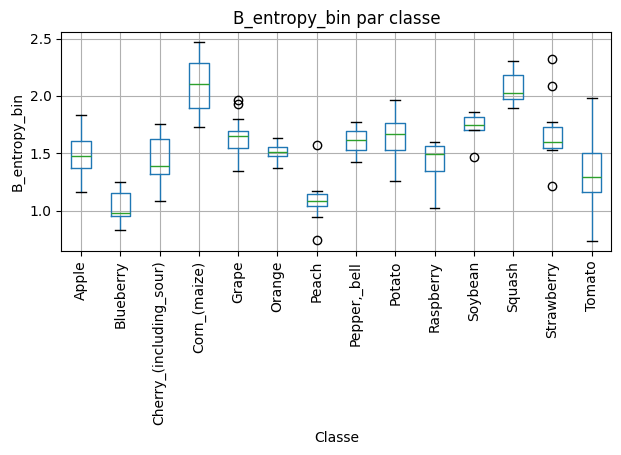

[R] 34 outliers détectés
[G] 32 outliers détectés
[B] 15 outliers détectés


In [12]:
# Calcul des résumés d’histogramme (16 bins) canal par canal
hist_cols = [c for c in df_sorted.columns if c.startswith("col_hist_bin")]
n_bins    = 16
channels  = ["R", "G", "B"]

for ic, ch in enumerate(channels):
    cols = hist_cols[ic * n_bins:(ic + 1) * n_bins]
    H    = df_sorted[cols].values           # (n_samples, 16)
    bins = np.arange(n_bins)
    sums = H.sum(axis=1) + 1e-6

    mean    = (H * bins).sum(axis=1) / sums
    var     = (H * (bins - mean[:,None])**2).sum(axis=1) / sums
    std     = np.sqrt(var)
    skew    = (H * (bins - mean[:,None])**3).sum(axis=1) / (sums * (std**3 + 1e-6))
    entropy = -(H * np.log(H + 1e-6)).sum(axis=1)

    dark_ratio   = H[:, 0] / sums
    bright_ratio = H[:, -1] / sums

    df_sorted[f"{ch}_mean_bin"]     = mean
    df_sorted[f"{ch}_std_bin"]      = std
    df_sorted[f"{ch}_skewness_bin"] = skew
    df_sorted[f"{ch}_entropy_bin"]  = entropy
    df_sorted[f"{ch}_dark_ratio"]   = dark_ratio
    df_sorted[f"{ch}_bright_ratio"] = bright_ratio

# Suppression des colonnes brutes d’histogramme
df_sorted.drop(columns=hist_cols, inplace=True)

# Boxplots par classe pour vérifier la discrimination
to_plot = []
for ch in channels:
    to_plot += [f"{ch}_mean_bin", f"{ch}_std_bin", f"{ch}_entropy_bin"]

for feat in to_plot:
    plt.figure(figsize=(10,4))
    df_sorted.boxplot(column=feat, by="class", rot=90)
    plt.title(f"{feat} par classe")
    plt.suptitle("")
    plt.xlabel("Classe")
    plt.ylabel(feat)
    plt.tight_layout()
    plt.show()

# Détection d’outliers (IQR) sur bright_ratio
outliers = {}
for ch in channels:
    col = f"{ch}_bright_ratio"
    q1, q3 = df_sorted[col].quantile([0.25, 0.75])
    iqr    = q3 - q1
    mask   = (df_sorted[col] < (q1 - 1.5*iqr)) | (df_sorted[col] > (q3 + 1.5*iqr))
    outliers[ch] = df_sorted.loc[mask, "filepath"].tolist()
    print(f"[{ch}] {len(outliers[ch])} outliers détectés")


# Sauvegarde du DataFrame enrichi
output_csv = PROJECT_ROOT / "results" / "plantvillage_features_enriched.csv"
df_sorted.to_csv(output_csv, index=False, encoding="utf-8")

In [ ]:
# À partir des vecteurs d’histogramme (16 bins×3 canaux), on peut enrichier le dataframe avec d'autres infos :
# Peak_bin : 	Classe de teinte dominante
# Mean_bin : Position moyenne du pic (tendance générale)
# Std_bin : Dispersion des teintes (taches localisées)
# Skewness_bin : Asymétrie vers sombre ou clair
# Entropy : Complexité de la distribution (multi-pics…)
# Dark_ratio : Proportion de zones très sombres (ombre, bruit)
# Bright_ratio : Proportion de zones très claires

# calcul canal par canal


In [ ]:
# ANALYSE des  distributions

# Classes bien séparées sur la couleur (médianes très décalées et peu de recouvrement) >>> ces features seront fortes pour un classifieur ML classique (SVM, RF):
# Corn_(maize)
# Strawberry : R_mean_bin et G_mean_bin très hauts (médianes ~4–5), B_mean_bin exceptionnellement haut (~5+ pour quelques images).
# >>>  La fraise ressort bien par sa dominante rouge / vert.
# Blueberry, Cherry_(including_sour) et Raspberry

# Celles qui sont proches (médianes et IQR très recouverts ; p. ex. Orange, Grape, Soybean, Peach et Pepper_bell sur R_mean_bin):
# Orange vs Grape vs Soybean vs Peach vs Pepper_bell > Ces classes sont difficiles à séparer uniquement sur des stats couleur globales.

# Celles qui présentent une forte variance interne ( écart inter-quartile (IQR) très large ou moustaches étendues :
# Corn_(maize) : Très large IQR sur R_std_bin et G_std_bin : certaines images sont très homogènes, d’autres très contrastées.
# Strawberry : quelques « moustaches » et outliers lointains, signe d’images très claires ou fortement saturées.
# Orange et Grape (dans une moindre mesure) : G_std_bin et B_std_bin montrent des dispersions notables (quelques images très tachetées)




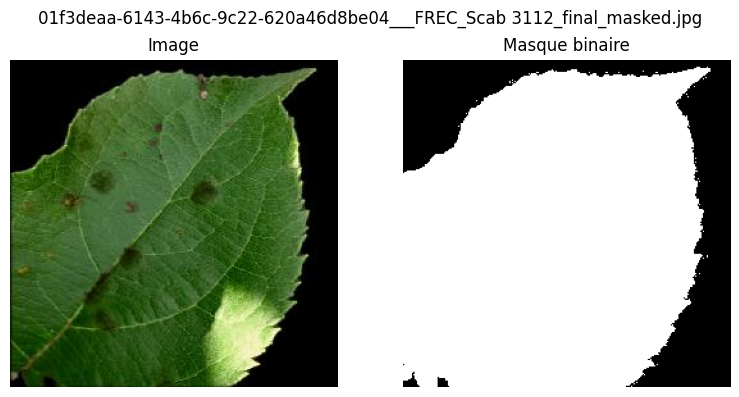

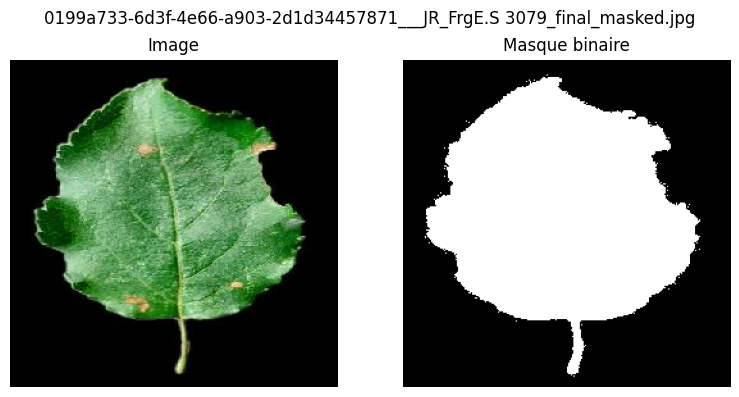

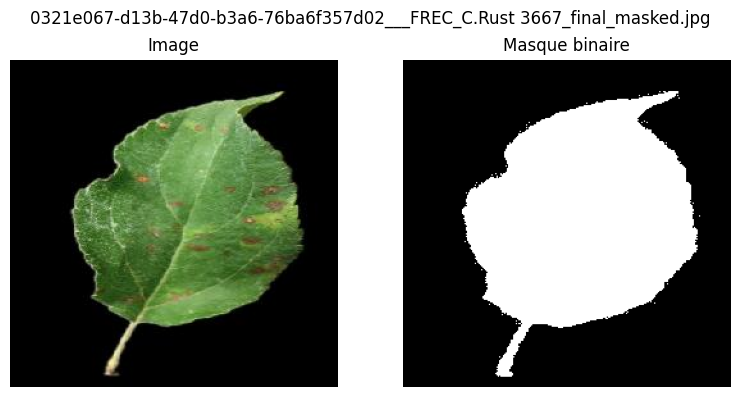

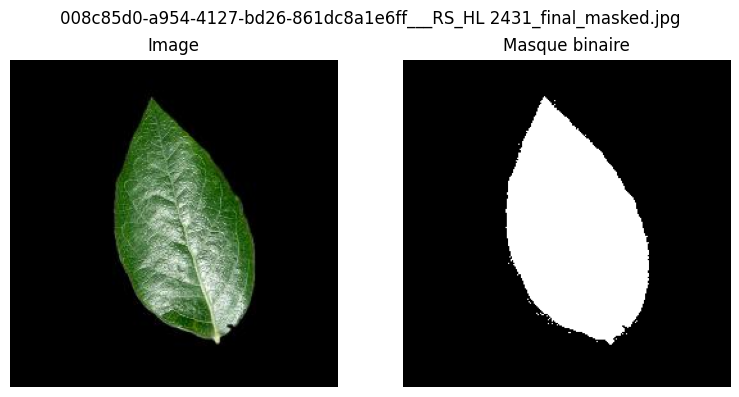

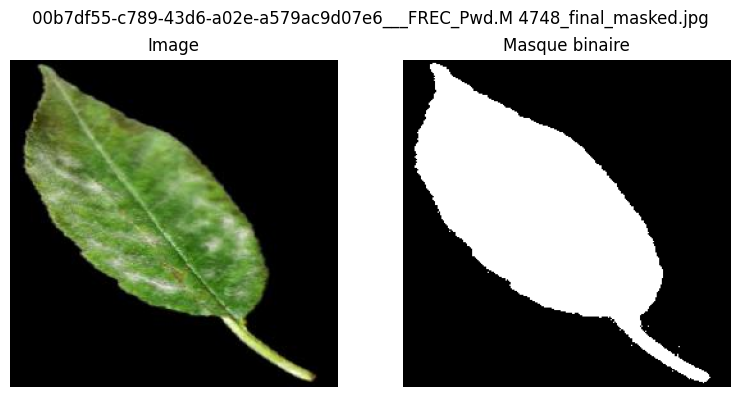

In [13]:
def inspect_outliers(filepaths, mask_threshold=10, n=5):
    """
    Affiche les n premières images outliers côte-à-côte avec leur masque binaire.
    
    - filepaths : liste de chemins vers images à inspecter
    - mask_threshold : seuil pour binariser (grayscale > threshold)
    - n : nombre maximum d’images à afficher
    """
    for path in filepaths[:n]:
        # Lecture et conversion RGB
        img_bgr = cv2.imread(path)
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        
        # Création du masque binaire via seuillage simple
        gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
        _, mask = cv2.threshold(gray, mask_threshold, 255, cv2.THRESH_BINARY)
        
        # Affichage
        fig, axes = plt.subplots(1,2, figsize=(8,4), tight_layout=True)
        axes[0].imshow(img_rgb)
        axes[0].set_title("Image")
        axes[0].axis('off')
        
        axes[1].imshow(mask, cmap='gray')
        axes[1].set_title("Masque binaire")
        axes[1].axis('off')
        
        plt.suptitle(path.split('/')[-1])
        plt.show()

# Exemple : inspectez les outliers du canal R
inspect_outliers(outliers['R'], mask_threshold=10, n=5)

In [ ]:

# ajout d'une colonne pour flaguer les outlier (0/1) + quality (0/1)
# 1 si ni outlier et bonne qualité sinon 0
df_sorted[quality]

In [ ]:
df.groupby("disease")["filename"].count().sort_values(ascending=False).plot(kind='bar', figsize=(12,3), title="Nombre d'images par maladie")
plt.tight_layout()
plt.show()

In [ ]:
df["extension"].value_counts().plot(kind='bar', title="Extensions d'image")
plt.show()

In [ ]:
df[["width", "height"]].value_counts().plot(kind='bar', title="Résolution des images")